In [4]:
from google.colab import drive
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, Conv1D, Dropout, LSTM
from sklearn.model_selection import train_test_split

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [66]:
df = pd.read_csv("/content/drive/MyDrive/AI/dataset/Energy_Power_Weather.csv")
df

,kilowatt-hours,Date,TempMin,TempMax,Weather,Wind_speed,Humidity,ALLSKY_SFC_SW_DWN
0,2.165,2019-01-28,18.69,24.43,Patchy rain possible,2.81,88.88,1.99
1,6.470,2019-01-29,19.56,24.33,Patchy rain possible,3.48,88.50,2.83
2,9.157,2019-01-30,19.38,24.42,Patchy rain possible,3.29,87.06,5.41
3,16.269,2019-01-31,19.06,25.05,Sunny,1.98,82.44,5.83
4,8.447,2019-02-01,19.03,24.25,Moderate rain at times,2.64,83.88,5.06
...,...,...,...,...,...,...,...,...
1757,4.514,2023-11-20,21.48,25.49,Light rain shower,3.85,85.00,4.07
1758,11.096,2023-11-21,21.13,25.69,Patchy rain possible,2.61,82.06,4.53
1759,4.860,2023-11-22,22.58,27.11,Light rain shower,2.69,84.19,2.83
1760,13.984,2023-11-23,22.44,26.48,Light rain shower,3.73,85.31,4.98


In [87]:
weather = {'Patchy rain possible': 0.27,
           'Sunny': 0.99,
           'Moderate rain at times': 0.22,
           'Overcast': 0.5,
           'Partly cloudy': 0.67,
           'Cloudy': 0.56,
           'Heavy rain at times': 0.16,
           'Moderate or heavy rain shower': 0.11,
           'Light rain shower': 0.33,
           'Mist': 0.44,
           'Patchy light rain with thunder': 0.24,
           'Thundery outbreaks possible': 0.31,
           'Patchy light drizzle': 0.39,
           'Torrential rain shower': 0.01
}

df_weather = df.groupby("Weather").agg({"kilowatt-hours": "mean"}).reset_index()
df_weather["Values"] = df_weather["Weather"].map(weather)
df_weather = df_weather.sort_values("Values")
df_weather


,Weather,kilowatt-hours,Values
13,Torrential rain shower,4.486000,0.01
4,Moderate or heavy rain shower,9.765574,0.11
1,Heavy rain at times,11.414422,0.16
5,Moderate rain at times,12.235026,0.22
9,Patchy light rain with thunder,14.518000,0.24
10,Patchy rain possible,13.329482,0.27
12,Thundery outbreaks possible,18.044000,0.31
2,Light rain shower,9.870042,0.33
8,Patchy light drizzle,6.426000,0.39
3,Mist,13.732000,0.44


# 0. Khai phá dữ liệu

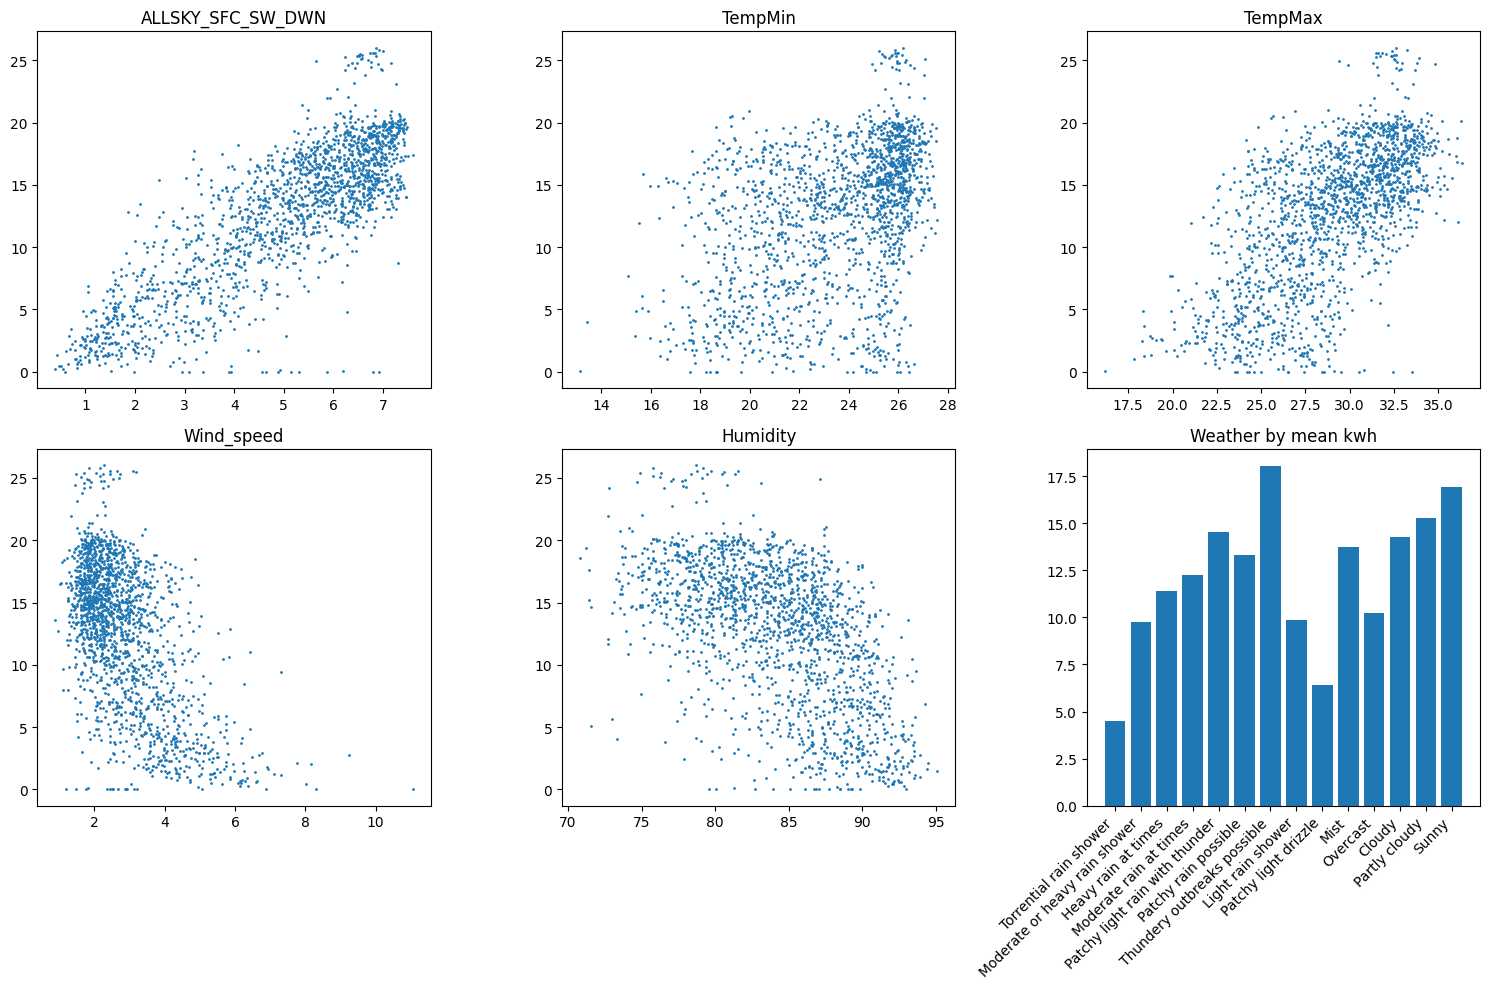

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.scatter(df['ALLSKY_SFC_SW_DWN'], df['kilowatt-hours'], s=1)
ax1.title.set_text("ALLSKY_SFC_SW_DWN")

ax2.scatter(df['TempMin'], df['kilowatt-hours'], s=1)
ax2.title.set_text("TempMin")

ax3.scatter(df['TempMax'], df['kilowatt-hours'], s=1)
ax3.title.set_text("TempMax")

ax4.scatter(df['Wind_speed'], df['kilowatt-hours'], s=1)
ax4.title.set_text("Wind_speed")

ax5.scatter(df['Humidity'], df['kilowatt-hours'], s=1)
ax5.title.set_text("Humidity")

ax6.bar(df_weather["Weather"], df_weather['kilowatt-hours'])
plt.xticks(rotation=45, ha="right")
ax6.title.set_text("Weather by mean kwh")

plt.tight_layout()
plt.show()

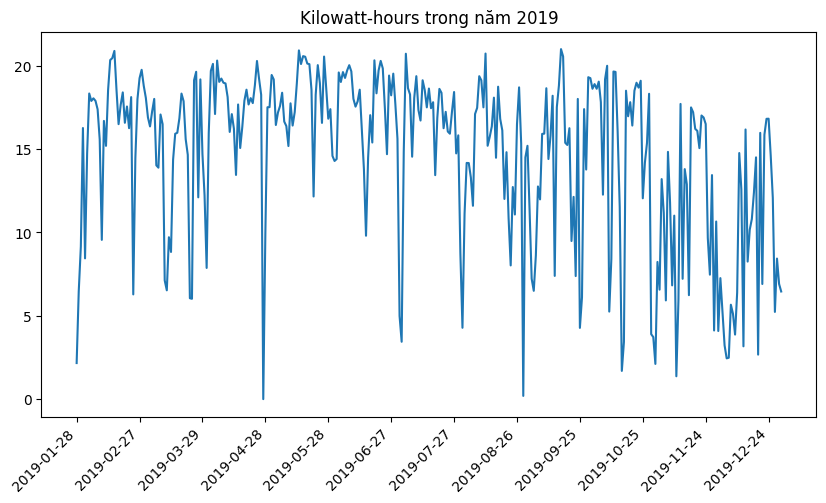

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][:337], df['kilowatt-hours'][:337], '-')
plt.xticks(range(0, 337, 30), rotation=45, ha="right")
plt.title("Kilowatt-hours trong năm 2019")
plt.show()

# 1. Tiền xử lý dữ liệu

In [43]:
# weather = {'Patchy rain possible': 0.27,
#            'Sunny': 0.99,
#            'Moderate rain at times': 0.22,
#            'Overcast': 0.5,
#            'Partly cloudy': 0.67,
#            'Cloudy': 0.56,
#            'Heavy rain at times': 0.16,
#            'Moderate or heavy rain shower': 0.11,
#            'Light rain shower': 0.33,
#            'Mist': 0.44,
#            'Patchy light rain with thunder': 0.24,
#            'Thundery outbreaks possible': 0.31,
#            'Patchy light drizzle': 0.39,
#            'Torrential rain shower': 0.01
# }

# df['Weather'] = df['Weather'].map(weather)

df["Date"] = pd.to_datetime(df["Date"])
df["Day_of_Year"] = df["Date"].dt.dayofyear
df = df.drop("Date", axis=1)
df = pd.get_dummies(df, columns=["Weather"]).astype(float)
df

,kilowatt-hours,TempMin,TempMax,Wind_speed,Humidity,ALLSKY_SFC_SW_DWN,Day_of_Year,Weather_Cloudy,Weather_Heavy rain at times,Weather_Light rain shower,Weather_Mist,Weather_Moderate or heavy rain shower,Weather_Moderate rain at times,Weather_Overcast,Weather_Partly cloudy,Weather_Patchy light drizzle,Weather_Patchy light rain with thunder,Weather_Patchy rain possible,Weather_Sunny,Weather_Thundery outbreaks possible,Weather_Torrential rain shower
0,2.165,18.0,23.0,2.81,88.88,1.99,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6.470,20.0,25.0,3.48,88.50,2.83,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9.157,21.0,24.0,3.29,87.06,5.41,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,16.269,21.0,25.0,1.98,82.44,5.83,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8.447,19.0,23.0,2.64,83.88,5.06,32.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,4.514,21.0,23.0,3.85,85.00,4.07,324.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1758,11.096,22.0,26.0,2.61,82.06,4.53,325.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1759,4.860,20.0,25.0,2.69,84.19,2.83,326.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1760,13.984,23.0,25.0,3.73,85.31,4.98,327.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Tạo dữ liệu

In [47]:
# X = []
# y = []

# n = 14
# m = 7

# dataframe = df.values
# for i in range(len(dataframe) - (m + n)):
#     X.append(dataframe[i:i+n])
#     y.append(dataframe[i+n:i+n+m, 2])
# X = np.array(X)
# y = np.array(y)

# print(X.shape, y.shape)
# df = df.drop(["Wind_speed",	"Humidity",	"ALLSKY_SFC_SW_DWN",	"Day_of_Year"], axis=1)
X = df.values[:, 1:]
y = df["kilowatt-hours"].values.reshape(-1, 1)
print(X.shape, y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

(1762, 20) (1762, 1)


In [45]:
print(X_train[0])

[ 24.    27.     4.98  91.38   4.58 335.     0.     1.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]


# 3. Huấn luyện

In [51]:
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

def build_model(X_train, y_train):
    samples, features = X_train.shape
    output_dim = y_train.shape[1]

    md = Sequential()
    md.add(Conv1D(64, padding="same", kernel_size=3, activation="relu", input_shape=(features, 1)))
    md.add(Conv1D(128, padding="same", kernel_size=3, activation="relu"))
    md.add(Dropout(0.1))
    md.add(Flatten())
    md.add(Dense(128, activation="relu"))
    md.add(Dropout(0.1))
    md.add(Dense(256, activation="relu"))
    md.add(Dropout(0.1))
    md.add(Dense(output_dim))

    stop = EarlyStopping(monitor="val_loss", patience=5)
    md.compile(loss="mse", optimizer="adam", metrics=["mae"])
    md.fit(X_train, y_train, batch_size=16, epochs=50, verbose=1, validation_data=(X_val, y_val), callbacks=[stop])
    return md

model = build_model(X_train, y_train)
print(model.evaluate(X_test, y_test, verbose=0))

Epoch 1/50
67/67 [==============================] - 2s 14ms/step - loss: 53.6386 - mae: 5.7440 - val_loss: 23.5381 - val_mae: 3.8727
Epoch 2/50
67/67 [==============================] - 1s 11ms/step - loss: 29.8743 - mae: 4.3806 - val_loss: 29.7581 - val_mae: 4.3928
Epoch 3/50
67/67 [==============================] - 1s 11ms/step - loss: 23.1756 - mae: 3.7944 - val_loss: 24.1266 - val_mae: 3.9574
Epoch 4/50
67/67 [==============================] - 1s 11ms/step - loss: 20.1115 - mae: 3.5886 - val_loss: 33.7776 - val_mae: 4.8678
Epoch 5/50
67/67 [==============================] - 1s 11ms/step - loss: 17.8383 - mae: 3.3102 - val_loss: 14.5941 - val_mae: 2.9902
Epoch 6/50
67/67 [==============================] - 1s 11ms/step - loss: 15.6879 - mae: 3.0617 - val_loss: 11.6363 - val_mae: 2.6213
Epoch 7/50
67/67 [==============================] - 1s 11ms/step - loss: 14.6074 - mae: 2.9694 - val_loss: 11.0012 - val_mae: 2.5185
Epoch 8/50
67/67 [==============================] - 1s 11ms/step - lo

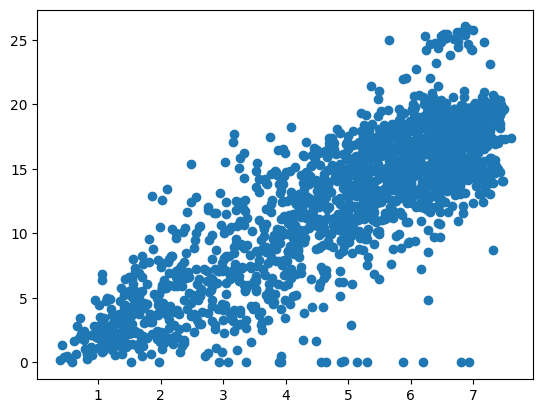

In [53]:
plt.plot(df['ALLSKY_SFC_SW_DWN'], df['kilowatt-hours'], 'o')
plt.show()